In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load
df = pd.read_csv('../data/train.csv')
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce', format='mixed')
df['Age'] = pd.Timestamp.today().year - df['Year_Birth']


In [2]:
# Basic cleanup
df['Customer_Tenure'] = (df['Dt_Customer'].max() - df['Dt_Customer']).dt.days
df['Total_Spent'] = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)
df['Total_Purchases'] = df[['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']].sum(axis=1)
df['Discount_Rate'] = df['NumDealsPurchases'] / (df['Total_Purchases'] + 1e-5)

df['Income'].fillna(df['Income'].median(), inplace=True)
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)

df.drop(columns=['ID', 'Year_Birth', 'Dt_Customer'], inplace=True)


/var/folders/zj/v5r_87m11hx637h9671k25y40000gn/T/ipykernel_10566/1442659774.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)


In [3]:
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = LGBMClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))


[LightGBM] [Info] Number of positive: 485, number of negative: 768
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2119
[LightGBM] [Info] Number of data points in the train set: 1253, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       192
           1       0.76      0.71      0.74       122

    accuracy                           0.80       314
   macro avg       0.79      0.79      0.79       314
weighted avg       0.80      0.80      0.80       314

ROC-AUC: 0.8885331284153005


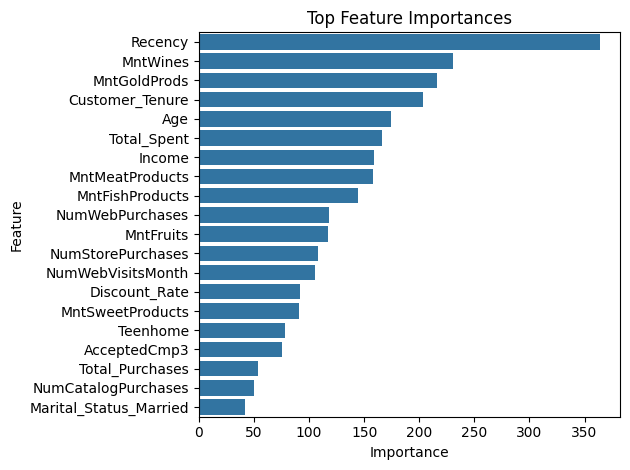

In [4]:
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feat_imp.sort_values('Importance', ascending=False, inplace=True)

sns.barplot(data=feat_imp.head(20), x='Importance', y='Feature')
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()


In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
print("RF ROC-AUC:", roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))


RF ROC-AUC: 0.8667605874316939
